In [1]:
import time
from uk_covid19 import Cov19API
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

## COVID-19 dashboard based on UK Government data published by Public Health England.

### CTRL-Click to select more than one category

In [23]:
# our API access function. This will be called by the button when it is clicked
def access_api():  
    filters1 = [
        "areaType=overview"
    ]

    structure1 = {
        "date": "date",
        "cases": "newCasesByPublishDate",
        "hospital": "hospitalCases",
        "deaths": "newDeaths28DaysByPublishDate",
    }
    
    filters2 = [
        'areaType=nation',
        'areaName=England'
    ]

    structure2 = {
        "date": "date",
        "hospital": "hospitalCases",
        "ventilator": "covidOccupiedMVBeds"
    }

    
    filters3 = [
        'areaType=nation',
        'areaName=England'
    ]

    structure3 = {
        "males": "maleCases",
        "females": "femaleCases"
    }
    
    
    api_overview = Cov19API(filters=filters1, structure=structure1)
    overview = api_overview.get_json()
    
    time.sleep(1)
    
    api_ventilator = Cov19API(filters=filters2, structure=structure2)
    ventilator = api_ventilator.get_json()
    
    time.sleep(1)
    
    api_age = Cov19API(filters=filters3, structure=structure3)
    age = api_age.get_json()

    with open("overview.json", "wt") as OUTF:
        json.dump(overview, OUTF)

    with open("ventilator.json", "wt") as OUTF:
        json.dump(ventilator, OUTF)

    with open("age.json", "wt") as OUTF:
        json.dump(age, OUTF)



    
# see the doc for the parameters    
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    icon='download' # (FontAwesome names without the `fa-` prefix)
)

# register the callback function with the button
apibutton.on_click(access_api())

# this is an iPython function that generalises print for Jupyter Notebooks; we use it to 
# display the widgets
display(apibutton)


def parse_date(date_string):
    ''' Convert a date string into a pandas datetime object '''
    return pd.to_datetime(date_string, format="%Y-%m-%d")


def create_df1(file):
    '''creates a pandas dataframe from a "json" dictionary from uk-covid19 API software development kit'''
    with open(file, "rt") as INFILE:
        data = json.load(INFILE)
    data_list =data['data']
    dates = [dictionary['date'] for dictionary in data_list]
    dates.sort()
    startdate = parse_date(dates[0])
    enddate = parse_date(dates[-1])
    
    index = pd.date_range(startdate, enddate, freq = 'D')
    df = pd.DataFrame(index=index, columns= ['cases', 'hospital','deaths'])
    
    for entry in data_list:
        date = parse_date(entry['date'])
        for column in ['cases', 'hospital', 'deaths']:
            if pd.isna(df.loc[date, column]):
                value = float(entry[column]) if entry[column] != None else 0.0
                df.loc[date, column] = value
                
    df.fillna(0.0, inplace = True)
    return df


def create_df2(file):
    '''creates a pandas dataframe from a "json" dictionary from uk-covid19 API software development kit'''
    with open(file, "rt") as INFILE:
        data = json.load(INFILE)
    data_list =data['data']
    dates = [dictionary['date'] for dictionary in data_list]
    dates.sort()
    startdate = parse_date(dates[0])
    enddate = parse_date(dates[-1])
    
    index = pd.date_range(startdate, enddate, freq = 'D')
    df = pd.DataFrame(index=index, columns= ['hospital','ventilator'])
    
    for entry in data_list:
        date = parse_date(entry['date'])
        for column in ['hospital','ventilator']:
            if pd.isna(df.loc[date, column]):
                value = float(entry[column]) if entry[column] != None else 0.0
                df.loc[date, column] = value
                
    df.fillna(0.0, inplace = True)
    return df


def create_df3(file):
    '''creates a pandas dataframe from a "json" dictionary from uk-covid19 API software development kit'''
    with open(file, "rt") as INFILE:
        data = json.load(INFILE)
    
    datadic=data['data'][0]
    males=datadic['males']
    females=datadic['females']
    
    ageranges=[x['age'] for x in males]
    
    def min_age(agerange):
        agerange=agerange.replace('+','') # remove the + from 90+
        start=agerange.split('_')[0]
        return int(start)

    ageranges.sort(key=min_age)
    
    df=pd.DataFrame(index=ageranges, columns=['Males','Females', 'Total'])
    
    
    for entry in males: 
        ageband=entry['age'] # our index position
        df.loc[ageband, 'Males']=entry['value']
    
    for entry in females:
        ageband=entry['age']
        df.loc[ageband, 'Females']=entry['value']
    
    df['Total']=df['Males']+df['Females']
    
    
    for entry in males: # each entry is a dictionary
        ageband=entry['age'] # our index position
        df.loc[ageband, 'Males']=entry['value']
    
    for entry in females:
        ageband=entry['age']
        df.loc[ageband, 'Females']=entry['value']
    

    df['Total']=df['Males']+df['Females']


    
    
                
    df.fillna(0.0, inplace = True)
    return df



Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click to download current Pu…

In [25]:
df1 = create_df1("overview.json")
df2 = create_df2("ventilator.json")
df3 = create_df3("age.json")

In [26]:
series1 = wdg.SelectMultiple(
    options=['cases', 'hospital', 'deaths'],
    value=['cases', 'hospital', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale1 = wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)

controls1 = wdg.HBox([series1, scale1])


series2 = wdg.SelectMultiple(
    options=['hospital', 'ventilator'],
    value=['hospital', 'ventilator'],
    rows=2,
    description='Stats:',
    disabled=False
)

scale2 = wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)

controls2 = wdg.HBox([series2, scale2])



def overview_graph(gcols, gscale):
    if gscale == 'linear':
        logscale = False
    else:
        logscale = True
    ncols = len(gcols)
    if ncols > 0:
        df1[list(gcols)].plot(logy=logscale, title="UK overview")
        
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

output_overview = wdg.interactive_output(overview_graph, {'gcols': series1, 'gscale': scale1})

display(controls1, output_overview)


def ventilator_graph(gcols, gscale):
    if gscale == 'linear':
        logscale = False
    else:
        logscale = True
    ncols = len(gcols)
    if ncols > 0:
        df2[list(gcols)].plot(logy=logscale, title="Occupied hospital beds and ventilators in England")
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

output_ventilator = wdg.interactive_output(ventilator_graph, {'gcols': series2, 'gscale': scale2})

display(controls2, output_ventilator)

    
    
    



Output()

Output()

Text(0, 0.5, 'Cases')

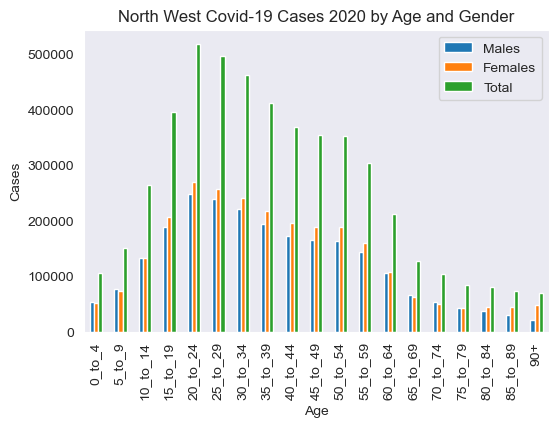

In [30]:

import seaborn as sns
sns.set_style("dark")
df3.plot(kind='bar', y=['Males','Females','Total'])
plt.title("North West Covid-19 Cases 2020 by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Cases")

#### (C) 2021 Karol Antoniuk. Data from Public Health England.